In [1]:
#These are the modules you will need
from xlayers import finegrid, layers
from xlayers.core import layers_numpy
from xlayers.core import layers_xarray

In [2]:
# Import some packages
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'


from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
#Look at what CMIP6 data is on the cloud
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/cmip6/pangeo-cmip6.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [4]:
#Load some of that CMIP6 data
df_theta = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == 'SAM0-UNICON') &
                         (df_theta.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_theta = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_salt = df[(df.table_id == 'Omon') & (df.variable_id == 'so')]
uri = df_salt[(df_salt.source_id == 'SAM0-UNICON') &
                         (df_salt.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_salt = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_v = df[(df.table_id == 'Omon') & (df.variable_id == 'vo')]
uri = df_v[(df_v.source_id == 'SAM0-UNICON') &
                         (df_v.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_v = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)

In [5]:
#find density from temperature and salinity
import gsw
dens = xr.apply_ufunc(gsw.density.sigma0, ds_salt['so'], ds_theta['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()

In [6]:
#this function calculates the quantities drF and drC from the depth levels of your model 
#(here lev_bnds defines the depth of each of the cell boundaries)
def finegrid_metrics(levs,lev_bnds):
    drF = np.diff(lev_bnds,axis=1)
    drC = np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [7]:
#actually apply the function
fine_drf,fine_drc = finegrid_metrics(ds_theta.lev.values,ds_theta.lev_bnds.values)

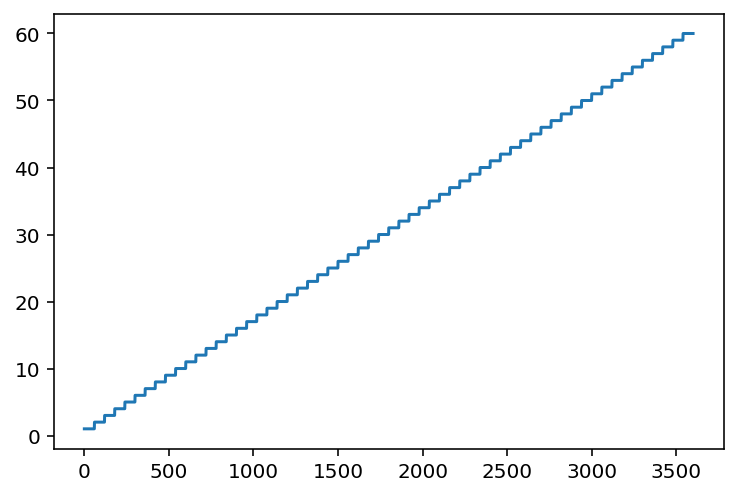

In [8]:
#Here we call the first xlayers function, finegrid, that calculates key parameters for rebinning the data
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10])
plt.plot(cellindex)

In [9]:
#here we define the new coordinate system
thetalayers = np.linspace(-3,31,80)

#this is the main function in xlayers: it is being applied to a single column here for demonstration purposes
VH = layers.layers_1(ds_v.vo[0,:,100,100].values, ds_theta.thetao[0,:,100,100].values,
                     thetalayers, mapfact, mapindex, cellindex, drf_finer)

In [10]:
#now we prepare more data to go into the "layers" function
v_in = ds_v.vo[0,:,:,:]#.transpose('lev','time','j','i')
theta_in = dens.dens[0,:,:,:]#.transpose('lev','time','j','i')

In [11]:
thetalayers = np.linspace(20,30,80)

#Here we apply the "layers" function to an xarray. 'lev' is the name of the vertical coordinate in our dataset
#'Tlev' is the name of the new coordinate
v_lay1 = layers_xarray(v_in, theta_in,thetalayers, 
                           mapfact, mapindex, cellindex, drf_finer, 'lev', 'Tlev')
#Note, v_lay1 is thickness weighted (i.e. if the input has units m/s, the output has units m^2/s)
#To transform back into non-thickness-weighted coordinates, find the thickness of each layer by using 
#xr.ones_like(v_in) as input, and divide through by this thickness

In [ ]:
#Here I basically plot the ROC from the thickness-weighted velocity. 
#Note: I have not summed with dx because I haven't had time to put it in
fig = plt.figure(figsize=(10,7))
(v_lay1).cumsum('Tlev').sum('i').plot(x='j',yincrease=False)